# Recurrent Neural Networks - LSTM

Predicting the stock price of Google from past stock prices (2012 - 2016)

Using an LSTM

Predict first month of 2017

Trying to predict trends rather than the actual price

## Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Importing the training set
# We will only train the RNN using the training set
# The model will not see the test set until after training

#Read in dataset in pandas
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
#Subset dataset to only take the Open column
#.values gives numpy array
training_set = dataset_train.iloc[:, 1:2].values
training_set

array([[ 325.25],
       [ 331.27],
       [ 329.83],
       ..., 
       [ 793.7 ],
       [ 783.33],
       [ 782.75]])

In [7]:
# Feature Scaling
# Normalisation is recommended for RNNs
# MinMaxScaler does this
# feature_range defines the scale, (0,1) normalises all values to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[ 0.08581368],
       [ 0.09701243],
       [ 0.09433366],
       ..., 
       [ 0.95725128],
       [ 0.93796041],
       [ 0.93688146]])

### Timesteps

60 timesteps = at each time t the RNN looks at the previous 60 stock prices and attempts to predict the next output

This parameter requires tuning to prevent over or underfitting

Below code creates the data strucure to facilitate this

X_train contains the previous 60 stock prices for every observation and y_train contains the corresponding next stock price

In [8]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train

array([[ 0.08581368,  0.09701243,  0.09433366, ...,  0.07846566,
         0.08034452,  0.08497656],
       [ 0.09701243,  0.09433366,  0.09156187, ...,  0.08034452,
         0.08497656,  0.08627874],
       [ 0.09433366,  0.09156187,  0.07984225, ...,  0.08497656,
         0.08627874,  0.08471612],
       ..., 
       [ 0.92106928,  0.92438053,  0.93048218, ...,  0.95475854,
         0.95204256,  0.95163331],
       [ 0.92438053,  0.93048218,  0.9299055 , ...,  0.95204256,
         0.95163331,  0.95725128],
       [ 0.93048218,  0.9299055 ,  0.93113327, ...,  0.95163331,
         0.95725128,  0.93796041]])

In [10]:
y_train

array([ 0.08627874,  0.08471612,  0.07454052, ...,  0.95725128,
        0.93796041,  0.93688146])

### Indicators

This tutorial uses a single indicator - Google's own stock prices over the last 5 years

The following datastructure makes it possible to add additional indicators to the LSTM such as stock prices from other, similar companies such as Amazon or additional columns from the dataset such as the Close price or Volumes

In [11]:
# Reshaping
# Adds another dimension to the X_train (model inputs)
# Second argument "newshape" gives new dimensions
# (A, B, C) - dimensions expected as input to Keras recurrent layers
# A = batch_size (no of lines in X_train)
# B = timesteps (no of columns in X_train)
# C = input_dim (no of indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build the RNN
Stacked LSTM

In [12]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [13]:
# Initialising the RNN
# Name regressor used here as we are predicting a continuous variable
regressor = Sequential()

In [14]:
# Adding the first LSTM layer and some Dropout regularisation
# units - number of LSTM cells or units in the layer. Larger numbers increases dimensionality.
# return_sequences - stacked LSTM with several layers
# input_shape - shape of the input X_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

#20% Dropout
#20% of neurons' ignored during training
regressor.add(Dropout(0.2))

In [15]:
# Adding a second LSTM layer and some Dropout regularisation
# Don't have to specify input shape here as we have already done so with the first layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [16]:
# Adding a third LSTM layer and some Dropout regularisation
# Exactly the same as adding the second layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [17]:
# Adding a fourth LSTM layer and some Dropout regularisation
# return_sequences = False here as this is the final LSTM layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [18]:
# Adding the output layer
# Fully connected layer - use Dense class
# units = 1 - Our desired output has only 1 dimension - it is a number
regressor.add(Dense(units = 1))

In [19]:
# Compiling the RNN
# OPTIMIZER 
# RMSprop usually recommended for LSTM
# adam used here 
# 
# LOSS
# mse used here as we are dealing with a regression not classification problem
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
# Fitting the RNN to the Training set
#As before with CNN and ANN
#100 epochs from trial and error - showed conversion on the loss
#Small dataset
#Batch Size = 32
#Weights updated every 32 datapoints
#Loss at the end of 100 epochs low but not so low to be suspicious of overfitting
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 21s - loss: 0.0576    
Epoch 2/100
1198/1198 [==============================] - 18s - loss: 0.0085    
Epoch 3/100
1198/1198 [==============================] - 18s - loss: 0.0061    
Epoch 4/100
1198/1198 [==============================] - 18s - loss: 0.0051    
Epoch 5/100
1198/1198 [==============================] - 18s - loss: 0.0050    
Epoch 6/100
1198/1198 [==============================] - 18s - loss: 0.0056    
Epoch 7/100
1198/1198 [==============================] - 20s - loss: 0.0055    
Epoch 8/100
1198/1198 [==============================] - 20s - loss: 0.0045    
Epoch 9/100
1198/1198 [==============================] - 18s - loss: 0.0047    
Epoch 10/100
1198/1198 [==============================] - 19s - loss: 0.0041    
Epoch 11/100
1198/1198 [==============================] - 19s - loss: 0.0039    
Epoch 12/100
1198/1198 [==============================] - 18s - loss: 0.0038    
Epoch 13/100
1198/1198 [=============

## Making predictions & visualising the result

In [21]:
# Getting the real stock price of 2017
#Import the test data into a dataframe
#Select the correct columns for the real results as with the training set
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [22]:
# Getting the predicted stock price of 2017
#To predict each new value, we need the 60 previous values. We need a test and training set for these
#Concatenate the actual training and test datasets - the original dataframes as read from CSV
#Then we scale these inputs as before - for consistency in data. Normalisation from sc object
#This does not change the original inputs

#Concatenate dataframes - axis=0 is vertical concatenation
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

#Need the stock prices from 60 days previous to the first prediction to day previous to the
#last prediction
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#Reshape the input to ensure numpy array
inputs = inputs.reshape(-1,1)

#Scale the inputs - as before minus the fit as we have already fit the scaling to the training set
inputs = sc.transform(inputs)

#Create the 3D input structure for the model
X_test = []
#Get the 60 previous inputs for each of the 20 inputs in January 2017
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

#convert list to numpy array
X_test = np.array(X_test)

#Reshape array into 3D format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Make prediction
predicted_stock_price = regressor.predict(X_test)

#Inverse scale the predicted results so they can be compared to the real values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


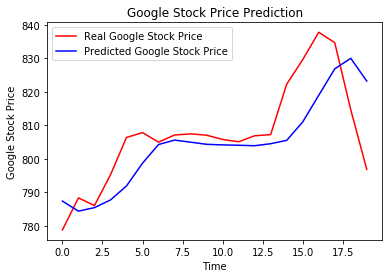

In [23]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
#Evaluation
#RMSE is a good measure of the closeness of the predicted values to the real values
#For the tutorial this was not as important as we were trying to predict the general trend and not the exact values
#The code here is given as an example of how you would measure RMSE in this case
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

#To get a relative error  rather than an absolute error - divide the RMSE by the range of the real values for Jan 2017